Step  1
Length:  19


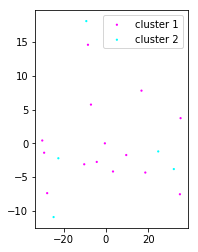

Step  2
Length:  19


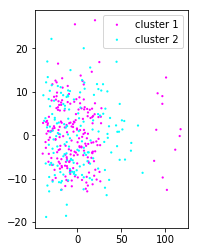

Step  3
Length:  367


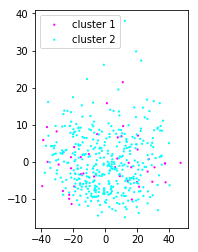

Step  4
Length:  450


C:\Users\Convidado\Anaconda3\lib\site-packages\sklearn\decomposition\pca.py:398: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var


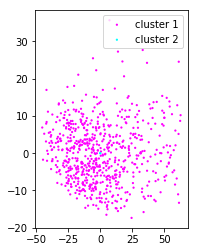

Step  5
Length:  680


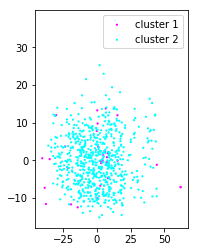

Step  6
Length:  699


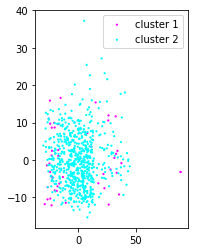

Step  7
Length:  695


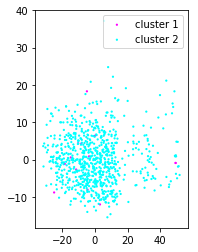

Step  8
Length:  814


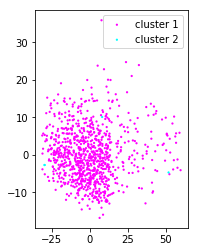

Step  9
Length:  956


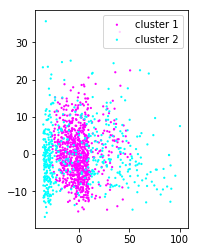

Step  10
Length:  1321


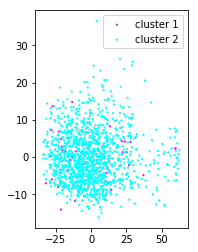

Step  11
Length:  1365


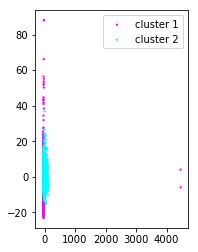

Step  12
Length:  1730


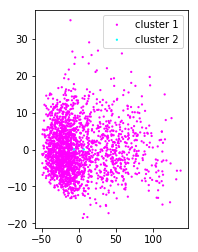

Step  13
Length:  2095


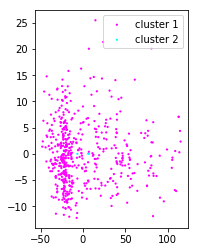

Step  14
Length:  515


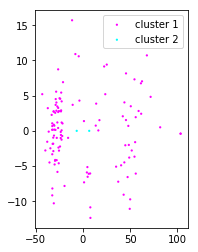

Step  15
Length:  122


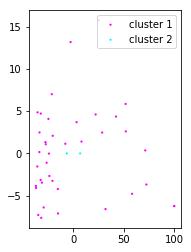

Step  16
Length:  41


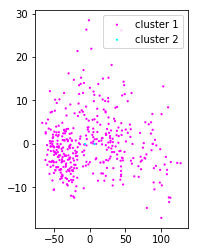

Step  17
Length:  406


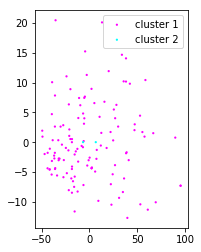

Step  18
Length:  126


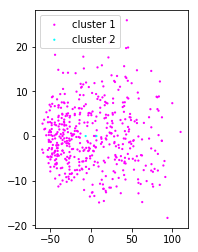

Step  19
Length:  491


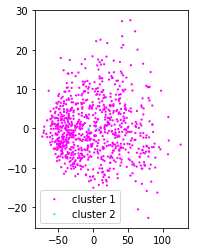

Step  20
Length:  856


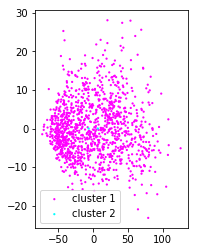

Step  21
Length:  1221


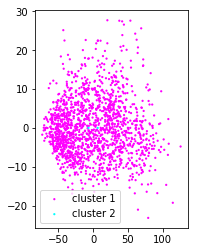

Step  22
Length:  1586


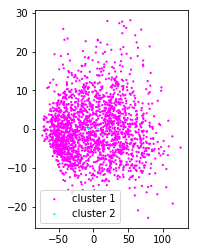

Step  23
Length:  1951


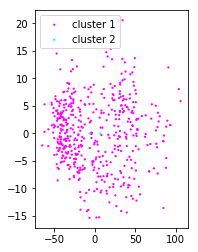

Step  24
Length:  488


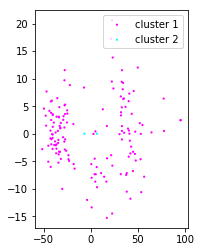

Step  25
Length:  152


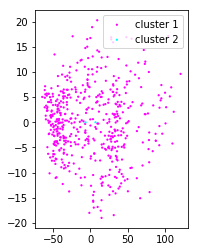

Step  26
Length:  517


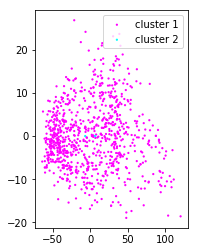

Step  27
Length:  882


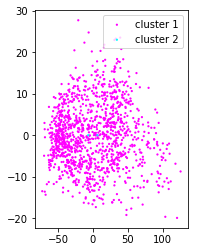

Step  28
Length:  1247


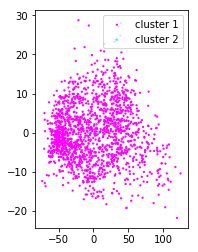

Step  29
Length:  1612


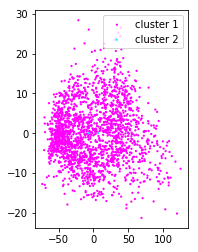

Step  30
Length:  1977


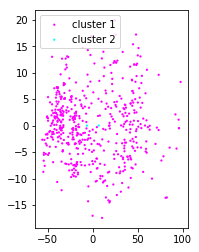

Step  31
Length:  500


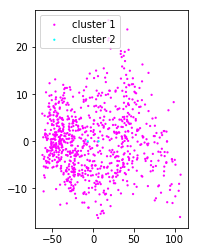

Step  32
Length:  865


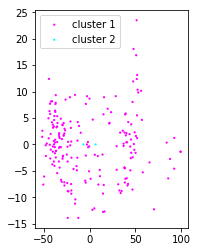

Step  33
Length:  203


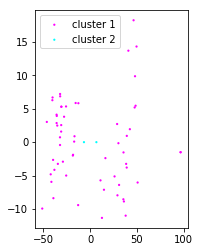

Step  34
Length:  61


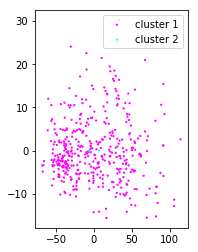

Step  35
Length:  426


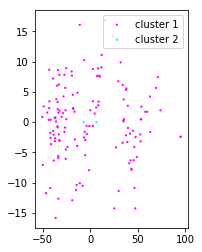

Step  36
Length:  139


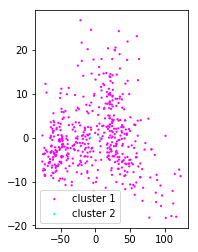

Step  37
Length:  504


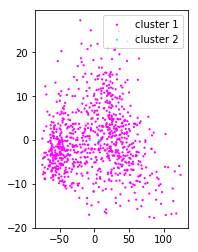

Step  38
Length:  869


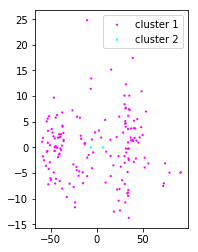

Step  39
Length:  165


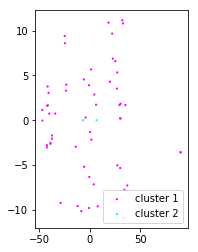

Step  40
Length:  58


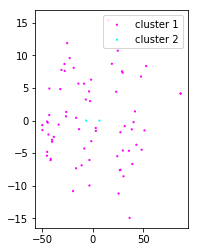

Step  41
Length:  70


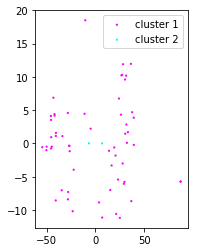

Step  42
Length:  60


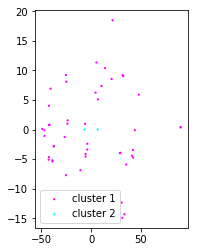

Step  43
Length:  49


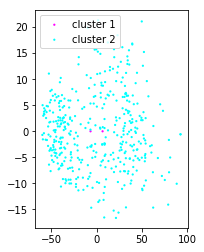

Step  44
Length:  414


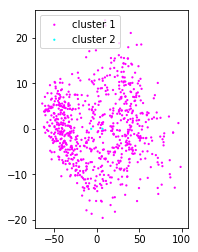

Step  45
Length:  779


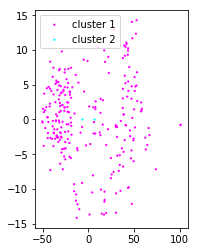

Step  46
Length:  254


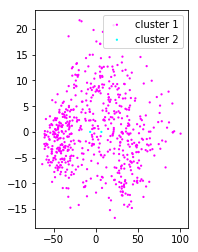

Step  47
Length:  619


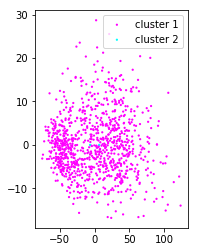

Step  48
Length:  984


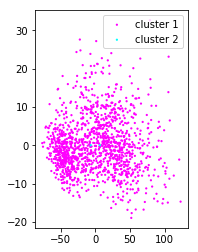

Step  49
Length:  1349


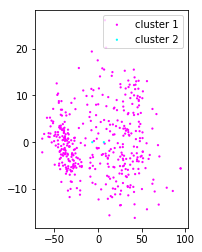

Step  50
Length:  414


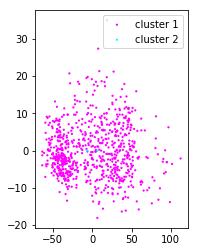

In [65]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import mixture
from sklearn.neighbors.kde import KernelDensity
from sklearn.cluster import KMeans
from sklearn import svm
from sklearn.decomposition import PCA


def pca(X, numComponents):
    pca = PCA(n_components=numComponents)
    pca.fit(X)
    PCA(copy=True, iterated_power='auto', n_components=numComponents, random_state=None, svd_solver='auto', tol=0.0, whiten=False)
    
    return pca.transform(X)
       
    
def kMeans(X, classes):  
    numClasses = len(classes)
    kmeans = KMeans(n_clusters=numClasses).fit(X)
    
    return kmeans


def svm(X, y):
    clf = svm.SVC()
    clf.fit(X, y)
    
    svm.SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
        decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
        max_iter=-1, probability=False, random_state=None, shrinking=True,
        tol=0.001, verbose=False)
    
    return clf
    

def gmm(points):
    clf = mixture.GaussianMixture(n_components=6, covariance_type='full')
    pdfs = np.exp(clf.fit(points).score_samples(points))
        
    return pdfs


def kde(points):
    kernel = KernelDensity(kernel='gaussian', bandwidth=0.2).fit(points)
    pdfs = np.exp(kernel.score_samples(points))
    
    return pdfs


def baseClassifier(instancesToPredict, classifier):
    return classifier.predict(instancesToPredict)


def initializingData(X, y):
    c1=[]
    c2=[]
    for i in range(len(y)):
        if y[i]==0:
            c1.append(X[i])
        else:
            c2.append(X[i])
    
    return c1, c2
    
    
def loadDensitiesByClass(instances, indexesByClass, densityFunction):
    pdfsByClass = {}
    for c, indexes in indexesByClass.items():
        pdfs = [-1] * len(instances)
        points = instances[indexes]
        pdfsByPoints = densityFunction(points)
        a = 0
        for i in indexes:
            pdfs[i]=pdfsByPoints[a]
            a+=1
        pdfsByClass[c] = pdfs
        
    return pdfsByClass


#Slicing instances according to their inferred clusters
def slicingClusteredData(clusters, classes):
    indexes = {}
    for c in range(len(classes)):
        indexes[classes[c]]=[i for i in range(len(clusters)) if clusters[i] == c]
    
    return indexes


#Cutting data for next iteration
def compactingDataDensityBased(instances, densities, criteria):
    selectedInstances=[]
    
    for k in densities:
        arrPdf = densities[k]
        maxPDF = max(arrPdf)*criteria
        minPDF = min(arrPdf)*criteria
        selectedInstances.append([instances[i] for i in range(len(arrPdf)) if arrPdf[i] != -1 and (arrPdf[i] >= maxPDF or arrPdf[i] <= minPDF)])
    return selectedInstances
    

def plotDistributions(distributions):
    i=0
    #ploting
    fig = plt.figure()
    handles = []
    colors = ['magenta', 'cyan']
    classes = ['cluster 1', 'cluster 2']
    ax = fig.add_subplot(121)
    
    for X in distributions:
        #reducing to 2-dimensional data
        x=pca(X, 2)
        
        handles.append(ax.scatter(x[:, 0], x[:, 1], color=colors[i], s=5, edgecolor='none'))
        i+=1
    
    ax.legend(handles, classes)
    
    plt.show()
    
    
def plotDistributionByClass(instances, indexesByClass):
    i=0
    #ploting
    fig = plt.figure()
    handles = []
    colors = ['magenta', 'cyan']
    classes = ['cluster 1', 'cluster 2']
    ax = fig.add_subplot(121)
    
    for c, indexes in indexesByClass.items():
        X = instances[indexes]
        #reducing to 2-dimensional data
        x=pca(X, 2)
        
        handles.append(ax.scatter(x[:, 0], x[:, 1], color=colors[i], s=5, edgecolor='none'))
        i+=1
    
    ax.legend(handles, classes)
    
    plt.show()
    
    
def main():
    #current directory
    path = os.getcwd() 

    '''
    Reading NOAA dataset:
    Eight  features  (average temperature, minimum temperature, maximum temperature, dew
    point,  sea  level  pressure,  visibility,  average wind speed, maximum  wind  speed)
    are  used  to  determine  whether  each  day  experienced  rain  or no rain.
    '''
    dataValues = pd.read_csv(path+'\\noaa_data.csv',sep = ",")
    dataLabels = pd.read_csv(path+'\\noaa_label.csv',sep = ",")


    ''' Test 0: 
    Predicting 365 instances by step. 50 steps. Starting labeled data with 5%. Two classes.
    '''
    excludingPercentage = 0.5
    batches = 50
    sizeOfBatch = 365
    sizeOfLabeledData = round((0.05)*sizeOfBatch)
    initialDataLength = sizeOfLabeledData
    finalDataLength = sizeOfBatch
    

    # ***** Box 0 *****
    X = dataValues.loc[:initialDataLength].copy()
    X = X.values
    y = dataLabels.loc[:initialDataLength].copy()
    y = y.values
    X_class1, X_class2 = initializingData(X, y)
    
    #Starting the process
    for t in range(batches):
        print("Step ",t+1)
        print(len(X), " Points")
        
        plotDistributions([X_class1, X_class2])

        # ***** Box 1 *****
        X = np.vstack([X_class1, X_class2])
        U = dataValues.loc[initialDataLength:finalDataLength].copy()
        Ut = U.values
        #Ut = [U[t], U[t+1]]
        #print("Selected unlabeled data: ", Ut)
        classes=[0, 1]

        # ***** Box 2 *****
        kmeans = kMeans(pca(X, 2), classes)
        clusters = kmeans.labels_
        predicted = baseClassifier(pca(Ut, 2), kmeans)
        instances = np.vstack([X, Ut])
        indexesByClass = slicingClusteredData(np.hstack([clusters, predicted]), classes)
        
        # ***** Box 3 *****
        #Testing with two different methods
        #pdfGmmByClass = loadDensitiesByClass(instances, indexesByClass, gmm)
        pdfKdeByClass = loadDensitiesByClass(instances, indexesByClass, kde)
        # Plotting data distribution by class
        #plotDistributionByClass(instances, indexesByClass)
        
        # ***** Box 4 *****
        #instancesGMM = compactingDataDensityBased(instances, pdfGmmByClass, excludingPercentage)
        instancesKDE = compactingDataDensityBased(instances, pdfKdeByClass, excludingPercentage)
        
        # ***** Box 5 *****
        #X = instancesGMM
        X_class1 = instancesKDE[0]
        X_class2 = instancesKDE[1]
        initialDataLength=finalDataLength+1
        finalDataLength+=sizeOfBatch
        
        
        
main()

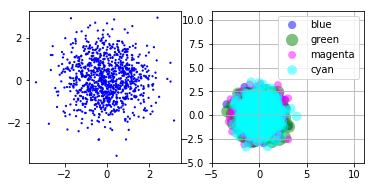

In [2]:
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure()
ax1 = fig.add_subplot(121)

## the data
N=1000
x = np.random.randn(N)
y = np.random.randn(N)

## left panel
ax1.scatter(x,y,color='blue',s=5,edgecolor='none')
ax1.set_aspect(1./ax1.get_data_ratio()) # make axes square


## right panel
ax2 = fig.add_subplot(122)
props = dict(alpha=0.5, edgecolors='none' )

handles = []
colors = ['blue', 'green', 'magenta', 'cyan']
for color in colors:
    x = np.random.randn(N)
    y = np.random.randn(N)
    s = np.random.randint(50,200)
    handles.append(ax2.scatter(x, y, c=color, s=s, **props))

ax2.set_ylim([-5,11])
ax2.set_xlim([-5,11])

ax2.legend(handles, colors)
ax2.grid(True)
ax2.set_aspect(1./ax2.get_data_ratio())
plt.show()